In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Creating time series

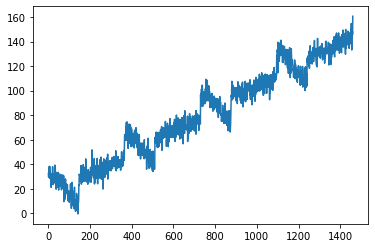

In [3]:
def trend(time, slope):
    return slope * time
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
        np.cos(2 * np.pi * season_time),
        1/np.exp(3 * season_time))
def seasonality(time, period, amplitude, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time=season_time)
def noise(time, noise_level, seed=None):
    rnd = np.random.RandomState(seed)
    return noise_level * rnd.randn(len(time))

baseline = 10
slope = 0.09
period = 365
amplitude = 20
noise_level = 5
seed = 42

time = np.arange(4 * 365 + 1, dtype='float32')
series = baseline + trend(time, slope) + seasonality(time, period=period, amplitude=amplitude) + noise(time, noise_level=noise_level, seed=seed)

plt.plot(time, series)

# Splitting into training and Validation
split_time = 1000
X_train = time[:split_time]
y_train = series[:split_time]
X_valid = time[split_time:]
y_valid = series[split_time:]

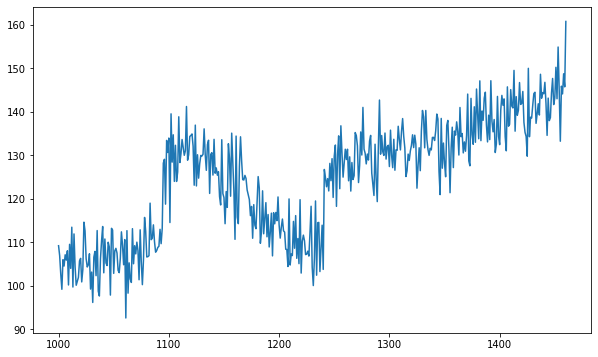

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(X_valid, y_valid)


# Creating windowed Dataset

In [5]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size = window_size + 1, shift = 1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window : window.batch(window_size + 1))
    dataset = dataset.shuffle(buffer_size=shuffle).map(lambda window : (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

window_size = 20
batch_size = 32

dataset = windowed_dataset(series, window_size=window_size, batch_size=batch_size, shuffle=1000)
print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>


In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9))
model.fit(dataset, epochs=100, verbose=True)


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
      1/Unknown - 0s 133ms/step - loss: 10750.7764

2021-10-28 19:27:37.258456: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-28 19:27:37.258614: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


46/46 [==============================] - 0s 1ms/step - loss: 12985.2960
Epoch 2/100
46/46 [==============================] - 0s 873us/step - loss: 9299.3069
Epoch 3/100
46/46 [==============================] - 0s 816us/step - loss: 8288.3282
Epoch 4/100
46/46 [==============================] - 0s 732us/step - loss: 7826.4216
Epoch 5/100
46/46 [==============================] - 0s 834us/step - loss: 7532.1063
Epoch 6/100
46/46 [==============================] - 0s 803us/step - loss: 7255.3324
Epoch 7/100
46/46 [==============================] - 0s 879us/step - loss: 7126.6665
Epoch 8/100
46/46 [==============================] - 0s 1ms/step - loss: 6986.5219
Epoch 9/100
46/46 [==============================] - 0s 857us/step - loss: 7048.8250
Epoch 10/100
46/46 [==============================] - 0s 734us/step - loss: 6977.5665
Epoch 11/100
46/46 [==============================] - 0s 1ms/step - loss: 6979.2984
Epoch 12/100
46/46 [==============================] - 0s 1ms/step - loss: 6755.5

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
MAE : 4.842586517333984, MSE : 38.13009262084961


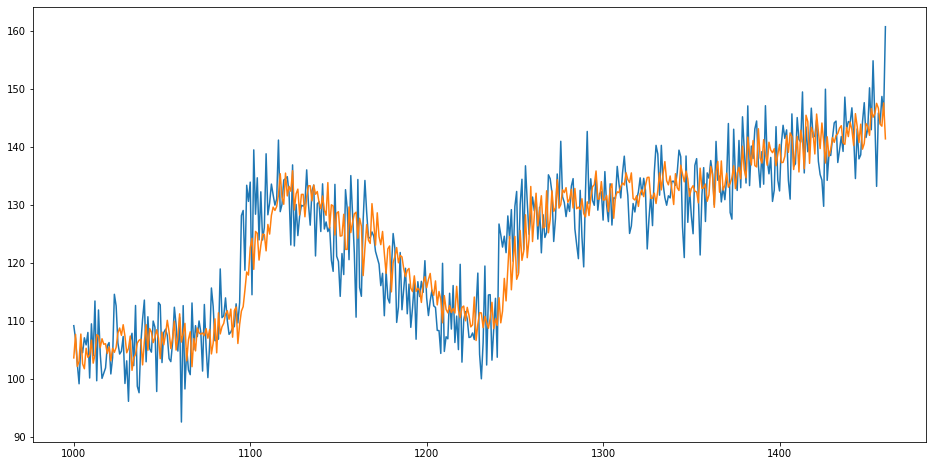

In [6]:
forecast = []
for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

results = np.array(forecast)[:, 0, 0][split_time - window_size:]

plt.figure(figsize=(16, 8))
plt.plot(X_valid, y_valid)
plt.plot(X_valid, results)

print('MAE : {}, MSE : {}'.format(tf.keras.metrics.mean_absolute_error(y_valid, results), tf.keras.metrics.mean_squared_error(y_valid, results)))

# Hyperparamter Tuning using Callbacks

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-8 * 10 ** (epoch / 20)
)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=False)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(0.001, 1e-08, 0.0, 300.0)

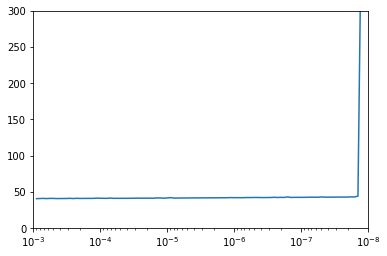

In [18]:
lrs = 1e-8 * 10 ** (np.arange(100) / 20)
loss = history.history['loss']
plt.semilogx(lrs, loss)
plt.axis([1e-3, 1e-8, 0, 300])

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=8e-8, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100, verbose=True)


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
46/46 [==============================] - 0s 1ms/step - loss: 13467.3000
Epoch 2/100
46/46 [==============================] - 0s 1ms/step - loss: 5784.8208
Epoch 3/100
46/46 [==============================] - 0s 1ms/step - loss: 826.8460
Epoch 4/100
46/46 [==============================] - 0s 1ms/step - loss: 44.9706
Epoch 5/100
46/46 [=================

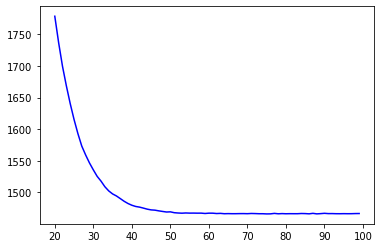

1466.0819091796875


In [15]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs[20:], loss[20:], 'b', label='Training Loss')
plt.show()
print(min(loss))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
MAE : 5.178950786590576, MSE : 43.67853546142578


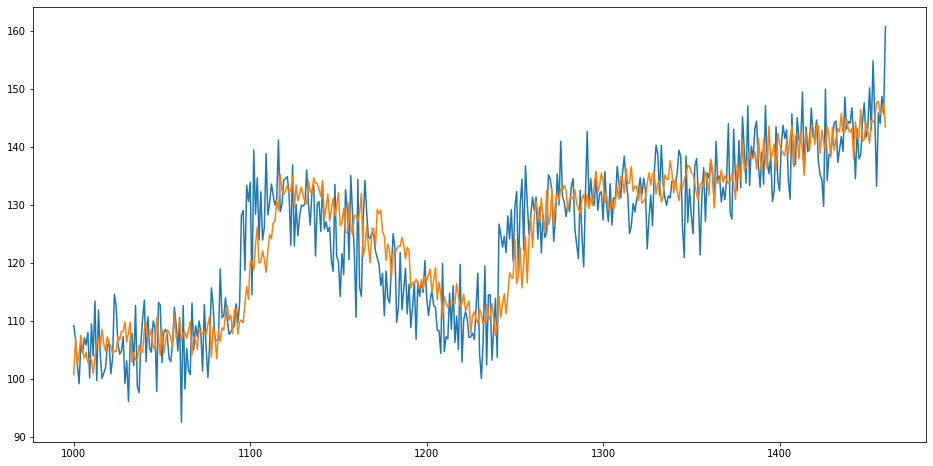

In [71]:
forecast = []
for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

results = np.array(forecast)[:, 0, 0][split_time - window_size:]

plt.figure(figsize=(16, 8))
plt.plot(X_valid, y_valid)
plt.plot(X_valid, results)

print('MAE : {}, MSE : {}'.format(tf.keras.metrics.mean_absolute_error(y_valid, results), tf.keras.metrics.mean_squared_error(y_valid, results)))